# Introduction

###  Challenge MDI341 2016-2017
#### Authors :  Umut Şimşekli & Alexandre Gramfort


For face recognition, researchers often build 'templates' (a vector of 128 float values) from high resolution images.  These templates are useful in certain applications where only low resolution images can be acquired and/or there is only low processing power (cpu/gpu) available.


The goal of this challenge is to learn a predictive system which predicts templates from **low** resolution images. The predicted templates should be as close as possible to original templates that were built from **high** resolution images.

You can use any method you like and any code you like (scikit-learn, tensorflow etc.). However the data provider suggested to see what a Convolutive Neural Network (CNN) could achieve. Again, while we will appreciate if you make it work with a Convolutive Neural Network, but you can use any method you like. However, **if you decide to use a CNN, then Tensorflow is mandatory**.



The properties of the dataset are as follows:

**Training data:**

$\textbf{X}_{train}$: size 100000 x 2304. Each row of this matrix contains a **low-resolution** image. There are 100000 images where each image is of size 48x48=2304.

$\textbf{Y}_{train}$: size 100000 x 128.  Each row of this matrix contains a template of size 128, which is previously learned from a **high-resolution** image

**Validation data:**

$\textbf{X}_{valid}$: size 10000 x 2304. There are 10000 images in this dataset.

$\textbf{Y}_{valid}$: size 10000 x 128.  

**Test data:**

$\textbf{X}_{test}$: size 10000 x 2304. There are 10000 images in this dataset similar to the validation set.

$\textbf{Y}_{test}$: size 10000 x 128.  (You do not have access to this matrix)



### The goal and the performance criterion

The goal is to build a model, which would produce templates for the test data, given $\textbf{X}_{train}$, $\textbf{Y}_{train}$, $\textbf{X}_{valid}$, $\textbf{Y}_{valid}$, and $\textbf{X}_{test}$. 

Let us call the prediction of the model: $\hat{\textbf{Y}}_{test}$. The performance criterion is given as follows:

$\text{score} = \frac1{N}\sum_{i=1}^{10000} \sum_{j=1}^{128} \Bigl(\textbf{Y}_{test}(i,j) - \hat{\textbf{Y}}_{test}(i,j) \Bigr)^2 $

where $N$ denotes the total number of elements in $\textbf{Y}_{test}$, such that $N=128 \times 10000$.

The lower the score, the better the performance.

# Important Rule 

For those of you willing to use a CNN with Tensorflow, to avoid giving advantages to participants with access to large amount of GPU/CPU, and to fit the application needs, we put a constraint on the total number of parameters to be learned.

**The maximum number of parameters that your CNN can contain is limited to 50K! Again Tensorflow is mandatory in that case.** 

Whatever you use, at the end of the challenge you will need to submit your code along with your reports. If you use CNNs, you will also need to submit your model. Use your resources wisely!


# Training Data

Images: https://www.dropbox.com/s/yliqmubhr3ywjza/data_train.bin

Templates: https://www.dropbox.com/s/berwg1hdv7z9kdf/fv_train.bin


# Validation Data

Images: https://www.dropbox.com/s/th9u6nqtyg0btqm/data_valid.bin

Templates: https://www.dropbox.com/s/qf8zf0rdoxm2hib/fv_valid.bin


# Test Data

Images: https://www.dropbox.com/s/zd4jnd95nr8kbtn/data_test.bin

In [39]:
# Package imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage import exposure
import pandas as pd
import keras
import tensorflow as tf
import seaborn as sns
from random import randint
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.optimizers import SGD, Adam, Adagrad, Nadam, Adamax
from keras.backend.tensorflow_backend import set_session
from keras.utils import np_utils
from keras.layers import Dense, Activation, LocallyConnected2D, LocallyConnected1D, LeakyReLU, AveragePooling1D, AveragePooling2D, Dropout
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU, LeakyReLU
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.morphology import binary_erosion, grey_erosion, grey_dilation, binary_dilation

## Loading and investigating the data

In [2]:
images_train_fname    = 'data_train.bin'
templates_train_fname = 'fv_train.bin'

images_valid_fname    = 'data_valid.bin'
templates_valid_fname = 'fv_valid.bin'

images_test_fname     = 'data_test.bin'

# number of images
num_train_images = 100000
num_valid_images = 10000
num_test_images  = 10000

# size of the images 48*48 pixels in gray levels
image_dim = 48 * 48

# dimension of the templates
template_dim = 128

# read the training files
with open(templates_train_fname, 'rb') as f:
    train_template_data = np.fromfile(f, dtype=np.float32, count=num_train_images * template_dim)
    train_template_data = train_template_data.reshape(num_train_images, template_dim)

with open(images_train_fname, 'rb') as f:
    train_image_data = np.fromfile(f, dtype=np.uint8, count=num_train_images * image_dim).astype(np.float32)
    train_image_data = train_image_data.reshape(num_train_images, image_dim)

# read the validation files
with open(templates_valid_fname, 'rb') as f:
    valid_template_data = np.fromfile(f, dtype=np.float32, count=num_valid_images * template_dim)
    valid_template_data = valid_template_data.reshape(num_valid_images, template_dim)

with open(images_valid_fname, 'rb') as f:
    valid_image_data = np.fromfile(f, dtype=np.uint8, count=num_valid_images * image_dim).astype(np.float32)
    valid_image_data = valid_image_data.reshape(num_valid_images, image_dim)

# read the test file
with open(images_test_fname, 'rb') as f:
    test_image_data = np.fromfile(f, dtype=np.uint8, count=num_test_images * image_dim).astype(np.float32)
    test_image_data = test_image_data.reshape(num_test_images, image_dim)

In [3]:
X_train = train_image_data 
X_test = test_image_data 
X_valid = valid_image_data 
y_train = train_template_data
y_valid = valid_template_data

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)

(100000, 2304)
(100000, 128)
(10000, 2304)
(10000, 128)
(10000, 2304)


/home/ubuntu/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


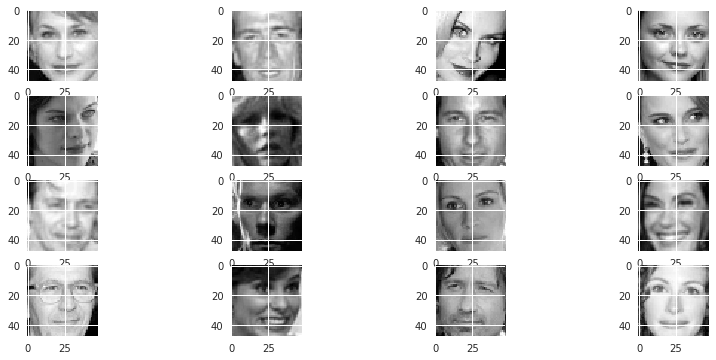

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(14, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    #print(i)
    ax.imshow(train_image_data[i+randint(1,5000)].reshape(48, 48), cmap=plt.cm.gray)

#### Cost Functions :

In [5]:
# Performance measure
def compute_pred_score(y_true, y_pred):
    err_y = np.mean((y_true - y_pred) ** 2)
    return err_y

In [6]:
def pred_score(y_true, y_pred):
    err_y = keras.backend.mean((y_true - y_pred) ** 2)*10000.
    return err_y

In [7]:
def loss_10(y_true, y_pred):
    return keras.backend.mean(keras.backend.square(y_pred - y_true), axis=-1)*10000.

## Neural Networks :

#### Neural Network with no convolutions :

In [8]:
def compute_pred_score(y_true, y_pred, col=None):
    if col==None:
        err_y = np.mean((y_true - y_pred) ** 2)
    else:
        err_y = np.mean((y_true[:, col] - y_pred) ** 2)
    return err_y

In [13]:
def fc_layer(tensor, input_dim, output_dim): 
    Winit = tf.truncated_normal([input_dim, output_dim], stddev=0.1)
    W = tf.Variable(Winit)
    Binit = tf.constant(0.0, shape=[output_dim])
    B = tf.Variable(Binit)
    tensor = tf.matmul(tensor, W) + B
    return tensor

In [14]:
def get_total_param():
    total_parameters = 0
    #iterating over all variables
    for variable in tf.trainable_variables():  
        local_parameters=1
        shape = variable.get_shape()  #getting shape of a variable
        for i in shape:
            local_parameters*=i.value  #mutiplying dimension values
        total_parameters+=local_parameters
    return total_parameters

In [33]:
# Reset var context
tf.reset_default_graph()

with tf.name_scope('input'):
    # Define X data for TF: 48 * 48 image.
    X = tf.placeholder(tf.float32, [None, image_dim], name = "X")
    # Define y data for TF: a 128 array 
    y_target = tf.placeholder(tf.float32, [None, template_dim], name = "y_target")
    
with tf.name_scope('layer_1'):
    layer_1 = fc_layer(X, image_dim, 1)

with tf.name_scope('activation_1'):
    activation_1 = tf.nn.relu(layer_1)

with tf.name_scope('layer_2'):
    layer_2 = fc_layer(activation_1, 1, template_dim)

with tf.name_scope('activation_2'):
    activation_2 = tf.nn.relu(layer_2)

print "Number of parameters : ", get_total_param() 
y = fc_layer(activation_2, template_dim, template_dim)

# Loss function
with tf.name_scope('loss'):
    loss = tf.reduce_sum(tf.square(y - y_target))
    tf.summary.scalar('loss', loss)

# Optimization function
train_step = tf.train.GradientDescentOptimizer(1e-6).minimize(loss)

Number of parameters :  2561


In [40]:
# Initializing our session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Generating Tensorboard logs
writer = tf.summary.FileWriter("log_test", sess.graph)

saver = tf.train.Saver()
err = []
cur_pos = 0
batch_size = 128
nbIt = 5000

for it in range(nbIt):
    
    if cur_pos + batch_size > len(train_image_data):
        print("Train set browsed.")
        cur_pos = 0
        
    trainDict = {X: X_train[cur_pos : cur_pos + batch_size, : ], 
                 y_target: y_train[cur_pos : cur_pos + batch_size, : ]}

    cur_pos += batch_size
    sess.run(train_step, feed_dict=trainDict)
    
    if it % 100 == 0:
        # Generating prediction
        y_valid_pred = sess.run(y, {X: X_valid})
        tmp_score_valid = compute_pred_score(y_valid_pred, y_valid)
        # Comparing to the default validation score
        print("{} - Loss:{} - Validation score:{} - vs 0.00781218".format(it, sess.run(loss, feed_dict=trainDict), 
                                                                 tmp_score_valid))

              
# Saving the model
saver.save(sess, "./model.ckpt")

# Exiting
sess.close()
print("Done")

0 - Loss:127.957862854 - Valid score:1.15324115753 - vs 0.00781218
100 - Loss:127.802246094 - Valid score:0.00780878216028 - vs 0.00781218
200 - Loss:127.719490051 - Valid score:0.00780439702794 - vs 0.00781218
300 - Loss:127.854553223 - Valid score:0.00780053809285 - vs 0.00781218
400 - Loss:127.673370361 - Valid score:0.00779700931162 - vs 0.00781218
500 - Loss:127.568275452 - Valid score:0.00779432756826 - vs 0.00781218
600 - Loss:127.873435974 - Valid score:0.00779108749703 - vs 0.00781218
700 - Loss:127.612579346 - Valid score:0.00778865721077 - vs 0.00781218
Train set browsed.
800 - Loss:127.477760315 - Valid score:0.0077860346064 - vs 0.00781218
900 - Loss:127.411216736 - Valid score:0.00778375566006 - vs 0.00781218
1000 - Loss:127.446731567 - Valid score:0.00778082571924 - vs 0.00781218
1100 - Loss:127.535232544 - Valid score:0.00777851091698 - vs 0.00781218
1200 - Loss:126.888206482 - Valid score:0.00777650205418 - vs 0.00781218
1300 - Loss:127.37802124 - Valid score:0.0077748

This was the benchmark my first submission (other than the default one) that I compared all of the following results to.

#### Convolutional Neural Network :

In this snippet of code lies the convolutional neural network architecture that I chose and tried to make better. Originally, the neural network was in Tensorflow, but since Keras is permitted and so much easier to tune and work with with, I switched to Keras like all of the remaining contestants I suppose.

#### Preprocessing :

#### Scaling :

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [15]:
X_train = train_image_data 
X_test = test_image_data 
X_valid = valid_image_data 
y_train = train_template_data
y_valid = valid_template_data

# Scaling
X_train = scaler.fit_transform(train_image_data)
X_valid = scaler.transform(valid_image_data)
X_test = scaler.transform(test_image_data)

# Grey Dilation
X_train = grey_dilation(X_train, size=(1,1))
X_valid = grey_dilation(X_valid, size=(1,1))
X_test = grey_dilation(X_test, size=(1,1))

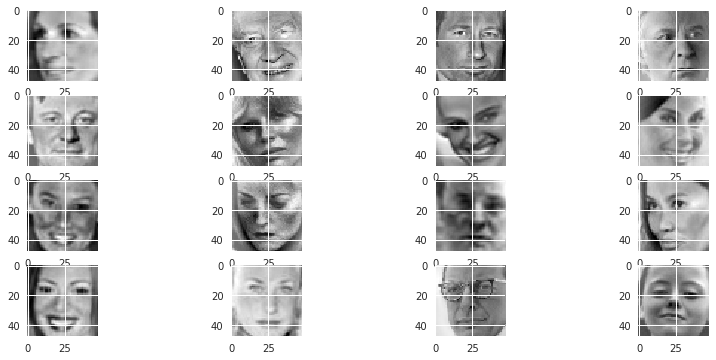

In [16]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(14, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(X_train[i+randint(1,5000)].reshape(48, 48), cmap=plt.cm.gray)

#### Gaussian Filters and Denoising :

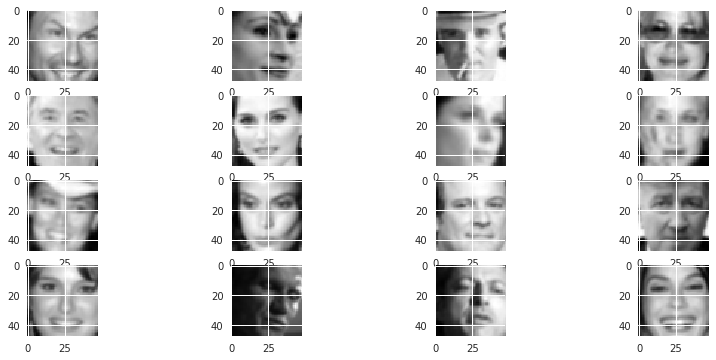

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(14, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(gaussian_filter(X_train[i+randint(1,5000)].reshape(48, 48), sigma = 0.75), cmap=plt.cm.gray)

#### Contrast Enhancement :

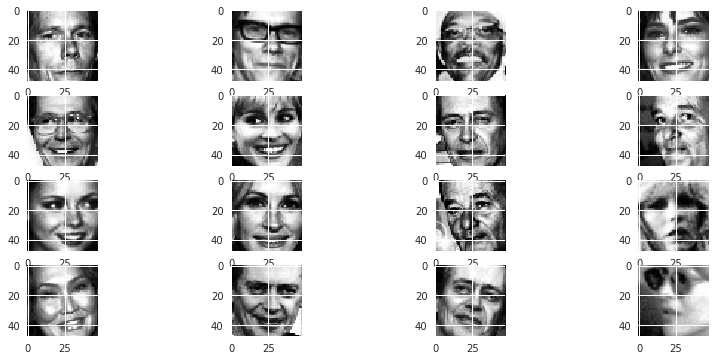

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(14, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(exposure.equalize_hist(X_train[i+randint(1,5000)].reshape(48, 48)), cmap=plt.cm.gray)

#### Erosion :

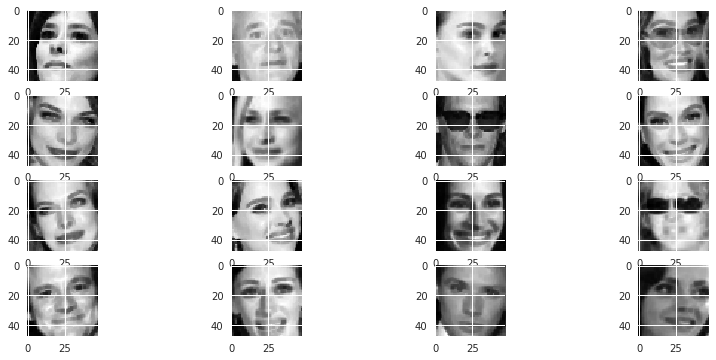

In [26]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(14, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(grey_erosion(X_train[i+randint(1,5000)].reshape(48, 48), size=(2,2)), cmap=plt.cm.gray)

#### Dilation :

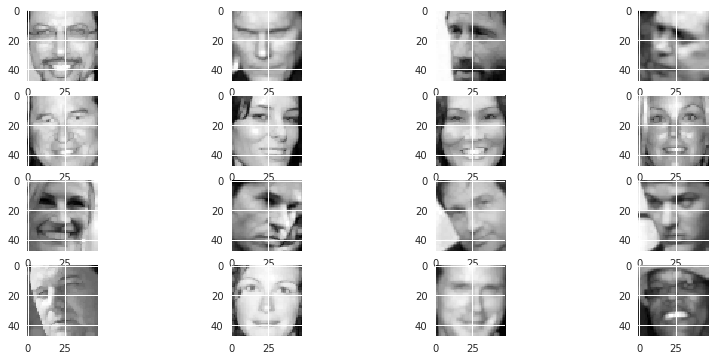

In [27]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(14, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(grey_dilation(X_train[i+randint(1,5000)].reshape(48, 48), size=(2,2)), cmap=plt.cm.gray)

#### Reshaping the data :

In [17]:
X_train = X_train.reshape((-1,48,48, 1))
X_valid = X_valid.reshape((-1,48,48, 1))
X_test = X_test.reshape((-1,48,48, 1))

#### Convolution Architecture :

In [43]:
tf.reset_default_graph()

In [44]:
model = Sequential()
tensorBoard = TensorBoard(log_dir='Test/', histogram_freq=0, write_graph=True, write_images=True)
checkpoint = ModelCheckpoint(filepath='Test/' + '-E_{epoch:02d}-L_{loss:.7f}.hdf5')

with tf.name_scope('Layer_1'):
    model.add(Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='same', input_shape=(48,48,1) ))
model.add(PReLU(shared_axes=[1,2]))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2,2) ) )


with tf.name_scope('Layer_2'):
    model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2,2) ) )


with tf.name_scope('Layer_3'):
    model.add(Conv2D(filters=40, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(PReLU(shared_axes=[1,2]))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2,2) ) )



with tf.name_scope('Layer_5'):
    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same'))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2,2) ) )

with tf.name_scope('Layer_6'):                  
    model.add(Dense(units=128))

model.add(Flatten())

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 16)        160       
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 48, 48, 16)        16        
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 32)        0         
__________

In [46]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.25
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

In [47]:
adam = Adam(lr=0.002,decay=0.00)
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=adam,
              metrics=[loss_10])

# Parameters init
N=100000
EPOCH=0
batch_size = 128

In [24]:
history = model.fit(X_train[:N], train_template_data[:N],batch_size=batch_size, epochs=EPOCH+5,verbose=1, initial_epoch=EPOCH,
                    validation_data=(X_valid, valid_template_data),
                    callbacks=[tensorBoard, checkpoint])

EPOCH = history.epoch[-1]+1

Train on 100000 samples, validate on 10000 samples
Epoch 1/5
100000/100000 [==============================] - 117s - loss: 0.0077 - loss_10: 77.0642 - val_loss: 0.0077 - val_loss_10: 76.8979
Epoch 2/5
100000/100000 [==============================] - 126s - loss: 0.0075 - loss_10: 75.0253 - val_loss: 0.0076 - val_loss_10: 75.7712
Epoch 3/5
100000/100000 [==============================] - 126s - loss: 0.0072 - loss_10: 72.2214 - val_loss: 0.0075 - val_loss_10: 74.6501
Epoch 4/5
100000/100000 [==============================] - 125s - loss: 0.0070 - loss_10: 69.7808 - val_loss: 0.0073 - val_loss_10: 73.4338
Epoch 5/5
100000/100000 [==============================] - 125s - loss: 0.0068 - loss_10: 68.0382 - val_loss: 0.0072 - val_loss_10: 72.4053


In [25]:
adam = Adam(lr=0.001,decay = 1e-6)

model.compile(loss=keras.losses.mean_squared_error,
              optimizer=adam,
              metrics=[loss_10])

In [26]:
history = model.fit(X_train, train_template_data[:N],batch_size=batch_size, epochs=EPOCH+5,verbose=1, initial_epoch=EPOCH,
                    validation_data=(X_valid, valid_template_data),
                    callbacks=[tensorBoard, checkpoint])

EPOCH = history.epoch[-1]+1

Train on 100000 samples, validate on 10000 samples
Epoch 6/10
100000/100000 [==============================] - 123s - loss: 0.0066 - loss_10: 66.2556 - val_loss: 0.0072 - val_loss_10: 71.5176
Epoch 7/10
100000/100000 [==============================] - 125s - loss: 0.0066 - loss_10: 65.5875 - val_loss: 0.0071 - val_loss_10: 71.0453
Epoch 8/10
100000/100000 [==============================] - 127s - loss: 0.0065 - loss_10: 65.0824 - val_loss: 0.0071 - val_loss_10: 70.7904
Epoch 9/10
100000/100000 [==============================] - 127s - loss: 0.0065 - loss_10: 64.7002 - val_loss: 0.0071 - val_loss_10: 70.8614
Epoch 10/10
100000/100000 [==============================] - 127s - loss: 0.0064 - loss_10: 64.3750 - val_loss: 0.0070 - val_loss_10: 70.4373


In [27]:
adam = Adam(lr=0.0005, decay = 1e-6)
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=adam,
              metrics=[loss_10])

In [28]:
history = model.fit(X_train[:N], train_template_data[:N],batch_size=batch_size, epochs=EPOCH+10,verbose=1, initial_epoch=EPOCH,
                    validation_data=(X_valid, valid_template_data),
                    callbacks=[tensorBoard, checkpoint])

EPOCH = history.epoch[-1]+1

Train on 100000 samples, validate on 10000 samples
Epoch 11/20
100000/100000 [==============================] - 127s - loss: 0.0064 - loss_10: 63.7148 - val_loss: 0.0070 - val_loss_10: 70.0184
Epoch 12/20
100000/100000 [==============================] - 129s - loss: 0.0064 - loss_10: 63.5522 - val_loss: 0.0070 - val_loss_10: 70.0689
Epoch 13/20
100000/100000 [==============================] - 129s - loss: 0.0063 - loss_10: 63.4245 - val_loss: 0.0070 - val_loss_10: 69.9305
Epoch 14/20
100000/100000 [==============================] - 129s - loss: 0.0063 - loss_10: 63.3187 - val_loss: 0.0070 - val_loss_10: 70.0283
Epoch 15/20
100000/100000 [==============================] - 127s - loss: 0.0063 - loss_10: 63.2254 - val_loss: 0.0070 - val_loss_10: 69.8888
Epoch 16/20
100000/100000 [==============================] - 109s - loss: 0.0063 - loss_10: 63.1278 - val_loss: 0.0070 - val_loss_10: 69.7100
Epoch 17/20
100000/100000 [==============================] - 106s - loss: 0.0063 - loss_10: 63.03

In [29]:
adam = Adamax(lr=0.0001,decay=1e-6)
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=adam,
              metrics=[loss_10])

In [30]:
history = model.fit(X_train, train_template_data[:N],batch_size=batch_size, epochs=EPOCH+5,verbose=1, initial_epoch=EPOCH,
                    validation_data=(X_valid, valid_template_data),
                    callbacks=[tensorBoard, checkpoint])

EPOCH = history.epoch[-1]+1

Train on 100000 samples, validate on 10000 samples
Epoch 21/25
100000/100000 [==============================] - 126s - loss: 0.0062 - loss_10: 62.3132 - val_loss: 0.0069 - val_loss_10: 69.3774
Epoch 22/25
100000/100000 [==============================] - 121s - loss: 0.0062 - loss_10: 62.2602 - val_loss: 0.0069 - val_loss_10: 69.3762
Epoch 23/25
100000/100000 [==============================] - 105s - loss: 0.0062 - loss_10: 62.2421 - val_loss: 0.0069 - val_loss_10: 69.3847
Epoch 24/25
100000/100000 [==============================] - 104s - loss: 0.0062 - loss_10: 62.2295 - val_loss: 0.0069 - val_loss_10: 69.3484
Epoch 25/25
100000/100000 [==============================] - 106s - loss: 0.0062 - loss_10: 62.2205 - val_loss: 0.0069 - val_loss_10: 69.3981


In [32]:
adam = Adam(lr=0.00001,decay=1e-7)
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=adam,
              metrics=[loss_10])

In [33]:
history = model.fit(X_train, train_template_data[:N],batch_size=batch_size, epochs=EPOCH+5,verbose=1, initial_epoch=EPOCH,
                    validation_data=(X_valid, valid_template_data),
                    callbacks=[tensorBoard, checkpoint])

EPOCH = history.epoch[-1]+1

Train on 100000 samples, validate on 10000 samples
Epoch 26/30
100000/100000 [==============================] - 106s - loss: 0.0062 - loss_10: 62.1787 - val_loss: 0.0069 - val_loss_10: 69.3486
Epoch 27/30
100000/100000 [==============================] - 103s - loss: 0.0062 - loss_10: 62.1745 - val_loss: 0.0069 - val_loss_10: 69.3458
Epoch 28/30
100000/100000 [==============================] - 103s - loss: 0.0062 - loss_10: 62.1718 - val_loss: 0.0069 - val_loss_10: 69.3459
Epoch 29/30
100000/100000 [==============================] - 102s - loss: 0.0062 - loss_10: 62.1691 - val_loss: 0.0069 - val_loss_10: 69.3346
Epoch 30/30
100000/100000 [==============================] - 101s - loss: 0.0062 - loss_10: 62.1667 - val_loss: 0.0069 - val_loss_10: 69.3325


In [34]:
print "Train score", compute_pred_score(train_template_data, model.predict(X_train))

Train score 0.0062153


In [35]:
print "Validation score", compute_pred_score(valid_template_data, model.predict(X_valid))

Validation score 0.00693325


In [42]:
# Saving the best performing model
model.save('./best_perf.h5')

#### Submission :

In [36]:
test_template_pred = model.predict(X_test)

f = open('template_pred.bin', 'wb')
for i in range(num_test_images):
    f.write(test_template_pred[i, :])
f.close()